# Representing Data and Engineering Features

In [1]:
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import warnings

from IPython.display import display
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

## Overview

이번장의 목표는 "Feature Analysis", "Feature Engineering"인 것 같습니다. 모든 데이터가 바로 머신러닝을 돌린다고 다 잘되는게 아니죠. 데이터를 잘 이해해서 노이즈를 없애고, 모델이 이해하기 쉽도록 데이터를 바꿔서 넣어주는 것이 중요합니다.

구성은 다소 정신없습니다. 책과 비슷하게 이정도를 노트북에서 연습하겠습니다.

- Categorical variables
- Binning, discretization, polynomials
- Feature selection
- Example: utilizing expert knowledge

## Categorical Variables

`OneHotEncoding`이라고 들어보셨나요? dummy 컬럼을 더 두어서 categorical 데이터를 binary 데이터로 만들어주는 것입니다. ([링크](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)) 보통 모델들은 string 값들은 모델링 할 수가 없으니 숫자로 바꿔 넣어야죠.

판다스를 사용하면 아주 쉽게 가능합니다. `pd.get_dummies()`가 있기 때문이죠. 

In [2]:
import os

# The file has no headers naming the columns, so we pass header=None
# and provide the column names explicitly in "names"
adult_path = os.path.join(mglearn.datasets.DATA_PATH, "adult.data")
data = pd.read_csv(
    adult_path, header=None, index_col=False,
    names=['age', 'workclass', 'fnlwgt', 'education',  'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'gender',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
           'income'])

# For illustration purposes, we only select some of the columns
data = data[['age', 'workclass', 'education', 'gender', 'hours-per-week',
             'occupation', 'income']]
display(data.head())

data_dummies = pd.get_dummies(data)
display(data_dummies.head())

,age,workclass,education,gender,hours-per-week,occupation,income
0,39,State-gov,Bachelors,Male,40,Adm-clerical,<=50K
1,50,Self-emp-not-inc,Bachelors,Male,13,Exec-managerial,<=50K
2,38,Private,HS-grad,Male,40,Handlers-cleaners,<=50K
3,53,Private,11th,Male,40,Handlers-cleaners,<=50K
4,28,Private,Bachelors,Female,40,Prof-specialty,<=50K


,age,hours-per-week,workclass_ ?,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,...,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,income_ <=50K,income_ >50K
0,39,40,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,50,13,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,38,40,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,53,40,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,28,40,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [3]:
features = data_dummies.ix[:, 'age':'occupation_ Transport-moving'] # Extract NumPy arrays
X = features.values
y = data_dummies['income_ >50K'].values

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Test score: {:.2f}".format(logreg.score(X_test, y_test)))

Test score: 0.81


## Binning, discretization, polynomials

`get_dummies`는 한 컬럼안에 categorical 값이 있을 경우에 잘 통하는 경우였죠?

이제는, categorical 값이 아닌, range 값이 있을 경우에 잘 나눠주는 것을 배우겠습니다. 단순히 구간으로 자르는 것에서 시작해서 (`binning`), `polynomial`로 만드는 것까지 해보겠습니다.

### Binning
`make_wave()`를 불러서 DT regressor, Linear regressor 를 불러봅니다.

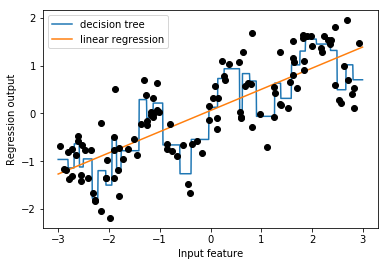

In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

X, y = mglearn.datasets.make_wave(n_samples=120)
line = np.linspace(-3, 3, 1000, endpoint=False).reshape(-1, 1)

reg = DecisionTreeRegressor(min_samples_leaf=3).fit(X, y)
plt.plot(line, reg.predict(line), label="decision tree")

reg = LinearRegression().fit(X, y)
plt.plot(line, reg.predict(line), label="linear regression")

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

In [5]:
from sklearn.preprocessing import KBinsDiscretizer

# 원래 값을 찍어보구요
print(X[:10])

# 이렇게 하면 sparse matrix 로 바꿔주고
kb = KBinsDiscretizer(n_bins=10, strategy='uniform')
kb.fit(X)
X_binned = kb.transform(X)
print(X_binned[:10])

# 이렇게 하면 dummy matrix 기반 one hot encoding 으로 binning 을 해줍니다.
kb = KBinsDiscretizer(n_bins=10, strategy='uniform', encode='onehot-dense')
kb.fit(X)
X_binned = kb.transform(X)
print(X_binned[:10])

[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]
 [-2.06403288]
 [-2.65149833]
 [ 2.19705687]
 [ 0.60669007]
 [ 1.24843547]]
  (0, 3)	1.0
  (1, 9)	1.0
  (2, 7)	1.0
  (3, 6)	1.0
  (4, 1)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 8)	1.0
  (8, 6)	1.0
  (9, 7)	1.0
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


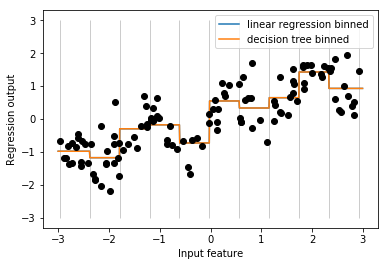

In [6]:
# bin 에 맞춰서 input 이 바뀌었으니 그에 맞게 binning 해줘서 모델링합니다.
line_binned = kb.transform(line)

reg = LinearRegression().fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='linear regression binned')

reg = DecisionTreeRegressor(min_samples_split=3).fit(X_binned, y)
plt.plot(line, reg.predict(line_binned), label='decision tree binned')
plt.plot(X[:, 0], y, 'o', c='k')
plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature");

책에서는 `np.digitize`, `OneHotEncoder`를 써서 여렵게했는데, 이제는 `KBinsDiscretizer`가 있어서 쉽게 코딩이 가능하네요.

### Interactions

Binning보다 조금 더 original 과 섞어서 모델링 해보겠습니다.

(120, 11)


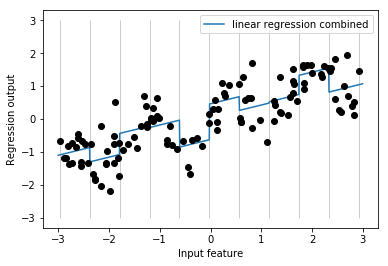

In [7]:
X_combined = np.hstack([X, X_binned])
print(X_combined.shape)


reg = LinearRegression().fit(X_combined, y)

line_combined = np.hstack([line, line_binned])
plt.plot(line, reg.predict(line_combined), label='linear regression combined')

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)
plt.legend(loc="best")
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.plot(X[:, 0], y, 'o', c='k');

$x^2$로 모델링 해볼수도 있죠.

(120, 20)


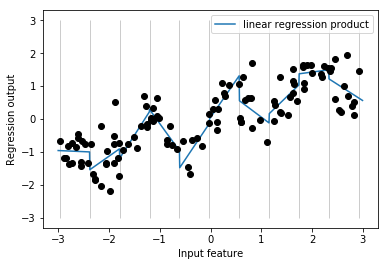

In [8]:
X_product = np.hstack([X_binned, X * X_binned])
print(X_product.shape)

reg = LinearRegression().fit(X_product, y)

line_product = np.hstack([line_binned, line * line_binned])
plt.plot(line, reg.predict(line_product), label='linear regression product')

plt.vlines(kb.bin_edges_[0], -3, 3, linewidth=1, alpha=.2)

plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

### Polynomials

네, 재밌습니다. 그렇게 original + binning 을 섞다가 보면 결국 원하는건 부드러운 곡선 모델링이 될껍니다. `PolynomialFeatures` 를 사용하면 바로 원하는 것을 얻을 수 있습니다.

X_poly.shape: (120, 10)
Entries of X:
[[-0.75275929]
 [ 2.70428584]
 [ 1.39196365]
 [ 0.59195091]
 [-2.06388816]]
Entries of X_poly:
[[-7.52759287e-01  5.66646544e-01 -4.26548448e-01  3.21088306e-01
  -2.41702204e-01  1.81943579e-01 -1.36959719e-01  1.03097700e-01
  -7.76077513e-02  5.84199555e-02]
 [ 2.70428584e+00  7.31316190e+00  1.97768801e+01  5.34823369e+01
   1.44631526e+02  3.91124988e+02  1.05771377e+03  2.86036036e+03
   7.73523202e+03  2.09182784e+04]
 [ 1.39196365e+00  1.93756281e+00  2.69701700e+00  3.75414962e+00
   5.22563982e+00  7.27390068e+00  1.01250053e+01  1.40936394e+01
   1.96178338e+01  2.73073115e+01]
 [ 5.91950905e-01  3.50405874e-01  2.07423074e-01  1.22784277e-01
   7.26822637e-02  4.30243318e-02  2.54682921e-02  1.50759786e-02
   8.92423917e-03  5.28271146e-03]
 [-2.06388816e+00  4.25963433e+00 -8.79140884e+00  1.81444846e+01
  -3.74481869e+01  7.72888694e+01 -1.59515582e+02  3.29222321e+02
  -6.79478050e+02  1.40236670e+03]]
Polynomial feature names:
['x0'

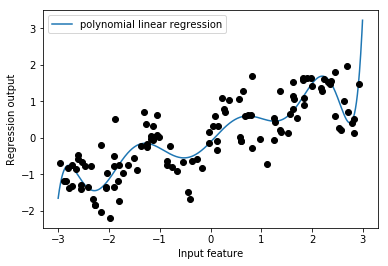

In [9]:
from sklearn.preprocessing import PolynomialFeatures

# include polynomials up to x ** 10:
# the default "include_bias=True" adds a feature that's constantly 1
poly = PolynomialFeatures(degree=10, include_bias=False)
poly.fit(X)
X_poly = poly.transform(X)

print("X_poly.shape: {}".format(X_poly.shape))
print("Entries of X:\n{}".format(X[:5]))
print("Entries of X_poly:\n{}".format(X_poly[:5]))

reg = LinearRegression().fit(X_poly, y)
print("Polynomial feature names:\n{}".format(poly.get_feature_names()))

line_poly = poly.transform(line)
plt.plot(line, reg.predict(line_poly), label='polynomial linear regression')
plt.plot(X[:, 0], y, 'o', c='k')
plt.ylabel("Regression output")
plt.xlabel("Input feature")
plt.legend(loc="best");

## Feature selection

ANOVA등을 통해 중요한 feature 들을 자동으로 뽑아주는 알고리즘들이 있습니다.
- SelectPercentile
- SelectFromModel
- RFE

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)
Test score: 0.940


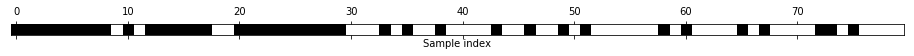

In [10]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

# get deterministic random numbers
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))
# add noise features to the data
# the first 30 features are from the dataset, the next 50 are noise
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)
# use f_classif (the default) and SelectPercentile to select 50% of features
select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)
# transform training set
X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_test_selected = select.transform(X_test)
score = LogisticRegression().fit(X_train_selected, y_train).score(X_test_selected, y_test)
print("Test score: {:.3f}".format(score))

mask = select.get_support()
#print(mask)
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(());

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)
Test score: 0.951


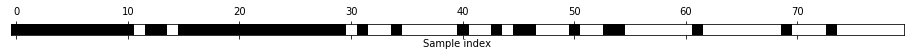

In [11]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

mask = select.get_support()
# visualize the mask. black is True, white is False
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(());

X_train.shape: (284, 80)
X_train_rfe.shape: (284, 40)
Test score: 0.951


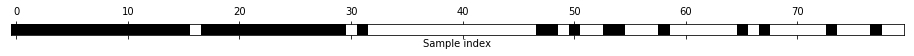

In [12]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)
X_train_rfe = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_rfe.shape: {}".format(X_train_rfe.shape))

X_test_rfe = select.transform(X_test)
score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

# visualize the selected features:
mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(());

## Example: utilizing Expert Knowledge

여태 배운것들 + 진짜 사람의 직관으로 데이터를 만지겠습니다.

`citibike`데이터를 사용해서 사용량을 예측해볼껀데요. 당연히 같은 요일, 같은 시간에 비슷하게 값이 나올꺼라고 예측할 수 있습니다. 우선, 그냥 모델링해봤다가, 요일, 시간에 맞춰서 모델을 개선해나가보겠습니다.

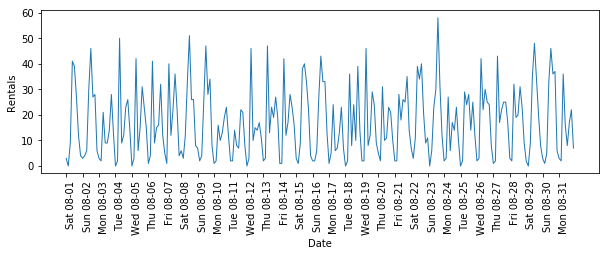

In [13]:
citibike = mglearn.datasets.load_citibike()

plt.figure(figsize=(10, 3))
xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(),
                       freq='D')
plt.xticks(xticks, xticks.strftime("%a %m-%d"), rotation=90, ha="left")
plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals");

In [14]:
# extract the target values (number of rentals)
y = citibike.values
# convert to POSIX time by dividing by 10**9
X = citibike.index.astype("int64").values.reshape(-1, 1) // 10**9

In [15]:
# use the first 184 data points for training, the rest for testing
n_train = 184

# function to evaluate and plot a regressor on a given feature set
def eval_on_features(features, target, regressor):
    # split the given features into a training and a test set
    X_train, X_test = features[:n_train], features[n_train:]
    # also split the target array
    y_train, y_test = target[:n_train], target[n_train:]
    regressor.fit(X_train, y_train)
    print("Test-set R^2: {:.2f}".format(regressor.score(X_test, y_test)))
    y_pred = regressor.predict(X_test)
    y_pred_train = regressor.predict(X_train)
    plt.figure(figsize=(10, 3))

    plt.xticks(range(0, len(X), 8), xticks.strftime("%a %m-%d"), rotation=90,
               ha="left")

    plt.plot(range(n_train), y_train, label="train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="test")
    plt.plot(range(n_train), y_pred_train, '--', label="prediction train")

    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--',
             label="prediction test")
    plt.legend(loc=(1.01, 0))
    plt.xlabel("Date")
    plt.ylabel("Rentals")

Test-set R^2: -0.04


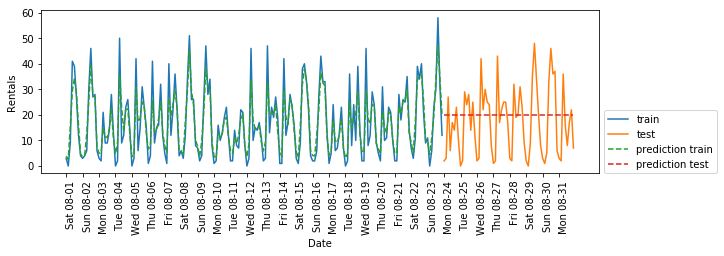

In [16]:
# 그냥 모델링
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, random_state=0)
eval_on_features(X, y, regressor);

Test-set R^2: 0.60


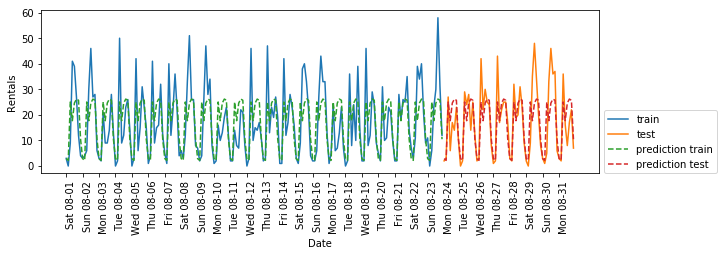

In [17]:
# 시간 고려해서 모델링
X_hour = citibike.index.hour.values.reshape(-1, 1)
eval_on_features(X_hour, y, regressor);

Test-set R^2: 0.84


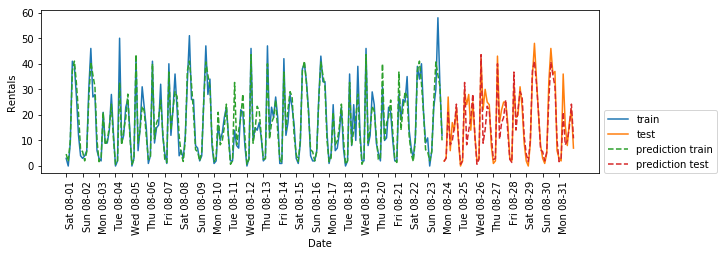

In [18]:
# 시간 요일 고려해서 모델링
X_hour_week = np.hstack([citibike.index.dayofweek.values.reshape(-1, 1),
                         citibike.index.hour.values.reshape(-1, 1)])
eval_on_features(X_hour_week, y, regressor);

Test-set R^2: 0.62


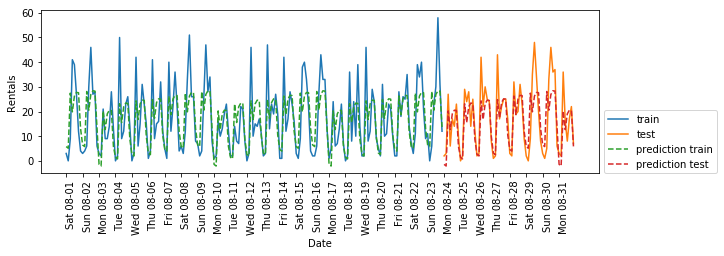

In [19]:
# LinearRegression 모델링 + OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

enc = OneHotEncoder()
X_hour_week_onehot = enc.fit_transform(X_hour_week).toarray()
eval_on_features(X_hour_week_onehot, y, Ridge());

Test-set R^2: 0.85


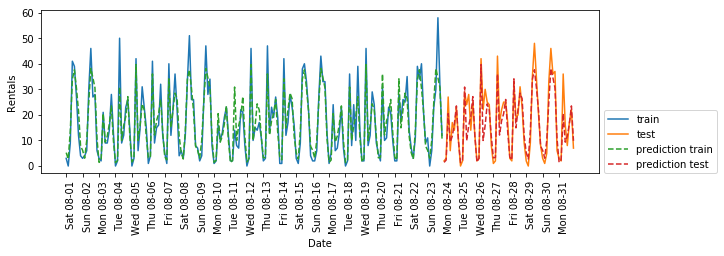

In [20]:
# LinearRegression 모델링 + OneHotEncoder + Poly
poly_transformer = PolynomialFeatures(degree=2, interaction_only=True,
                                      include_bias=False)
X_hour_week_onehot_poly = poly_transformer.fit_transform(X_hour_week_onehot)
lr = Ridge()
eval_on_features(X_hour_week_onehot_poly, y, lr);